In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [3]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)
f.close()

# import the function we want from that file
from plot_utility import plot_tme

# Constants

In [4]:
# Spring-mass-damper parameters
m = 1.0  # Mass (kg)
c = 0.5  # Damping coefficient (Ns/m)
k = 2.0  # Spring constant (N/m)
a = 0 # Constant force of 0 N

# Control Parameters
k_x = 0 # currently no control
k_xdot = 0

F0 = m*a

# Noise for measurements: (standard deviations)
v = [0.05, 0.05] # Position, velocity noise

# Desired trajectory

In [5]:
def desired_trajectory(t):
    x_desired = 0*np.ones_like(t)
    return x_desired

# Nonlinear continuous time dynamics with control

In [6]:
def control(X, t):
    x, xdot = np.ravel(X)
    
    # desired trajectory
    x_desired = desired_trajectory(t)
    
    # error
    x_err = x_desired - x
    
    # control
    F = (k_x*x_err)
    
    return F

In [7]:
def f(X, t):
    x, xdot = X
    
    # control
    F = control(X, t)
    
    # dynamics
    d_x = xdot
    d_xdot = (-k*x)/m -c*xdot/m + F0/m
    
    d_x = [d_x, d_xdot]
    
    return d_x

# Run simulation

In [8]:
t = np.arange(0, 10, 0.01) # Time

x0 = np.array([1.0, 0.0])  # Initial displacement and velocity

result = odeint(f, x0, t)
X = result.T

# Plot results

Plot the simulation results. These are the true states of the system. 

In [9]:
x = X[0, :]
xdot = X[1, :]

x_des = desired_trajectory(t)

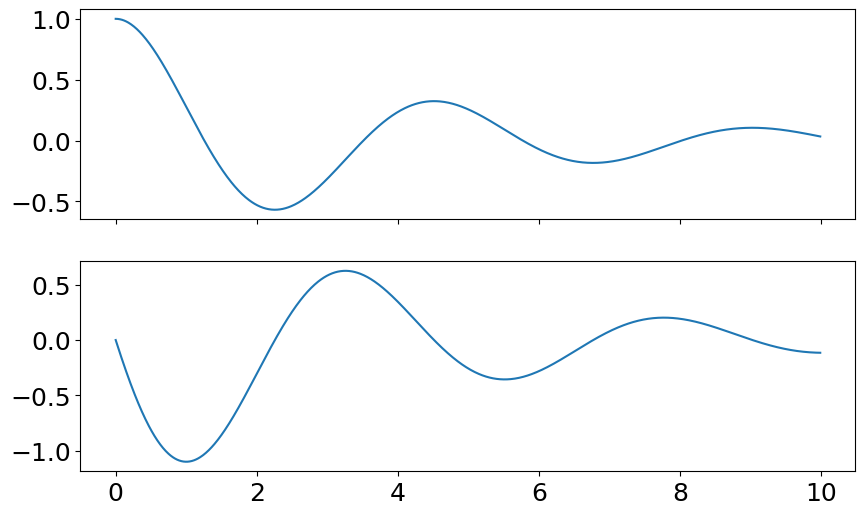

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True) 
# plot x and xdot
ax[0].plot(t, x, label='x')
# ax[0].plot(t, x_des, label='x_des', linestyle='--')
ax[1].plot(t, xdot, label='xdot')

# Measurements

Now, we will generate noisy measurements. 

In [11]:
def h(x, v):
    x, xdot = x
    
    y = np.array([x, xdot])
    noise = np.array( [np.random.normal(0, vi) for vi in v] )
    
    return (y + noise).tolist()

In [12]:
Y = np.vstack( [h(X[:,i], v) for i in range(X.shape[1]) ] ).T
print(np.shape(Y))

(2, 1000)


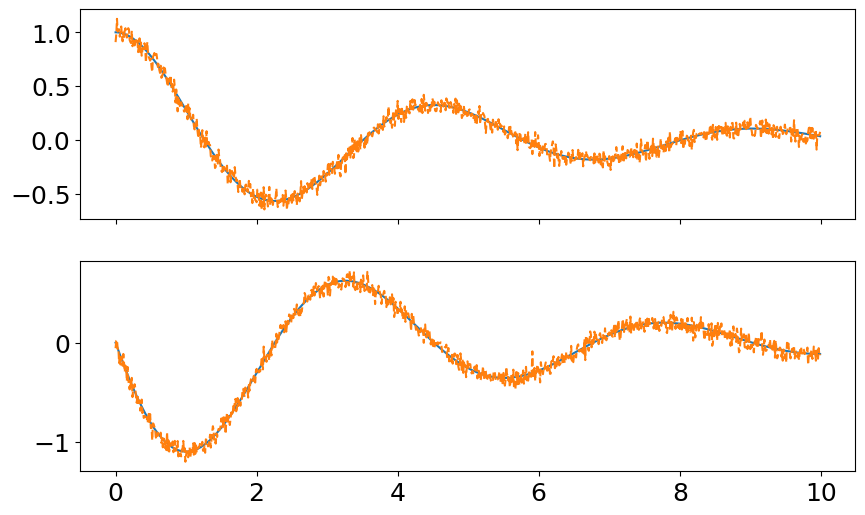

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True) 
# plot x and xdot
ax[0].plot(t, x, label='x')
ax[0].plot(t, Y[0, :], label='x_m', linestyle='--')
ax[1].plot(t, xdot, label='xdot')
ax[1].plot(t, Y[1, :], label='xdot_m', linestyle='--')

# Discrete Linearized

In [14]:
def control_linear(X, t):
    x, xdot = X
    
    # desired trajectory
    x_desired = desired_trajectory(t)
    
    # error
    x_err = x_desired - x
    
    # control
    F = (k_x*x_err)
    
    return F

In [15]:
# Here, we will define the dyanmics of the system
import itertools
dt = np.mean(np.diff(t))

A = np.array([[0, 1],
              [-k/m, -c/m]])

B = np.array([[0],
              [1/m]])

C_original = np.array([[1, 0],
                       [0, 1],
                       [1, 1],
                       [2, 0]])
# Get all the unique combinations of rows in C
print('C matrices:')
C = []
num_rows = len(C_original)
for r in range(1, num_rows + 1):  # r determines subset size
    for combo in itertools.combinations(C_original, r):
        print(np.array(combo))  # Each combo is a tuple of rows
        print()
        C.append(combo)

C matrices:
[[1 0]]

[[0 1]]

[[1 1]]

[[2 0]]

[[1 0]
 [0 1]]

[[1 0]
 [1 1]]

[[1 0]
 [2 0]]

[[0 1]
 [1 1]]

[[0 1]
 [2 0]]

[[1 1]
 [2 0]]

[[1 0]
 [0 1]
 [1 1]]

[[1 0]
 [0 1]
 [2 0]]

[[1 0]
 [1 1]
 [2 0]]

[[0 1]
 [1 1]
 [2 0]]

[[1 0]
 [0 1]
 [1 1]
 [2 0]]



# Organize some inputs for the KF

In [16]:
def get_params(Cmat):
    # get the control inputs -- these should be known
    u = control_linear(X, t)
    u = np.vstack(u).T

    # R is determined by the variance, thus the square of the standard deviation
    v = 0.05*np.eye(np.shape(Cmat)[0])
    R = np.diag(v)**2 # make sure R matches the dimensions of C!!!!! and Y
    R = np.atleast_2d(R)
    # Q defines how trustworthy the model is. More trusted models result in smoother estimates. 
    # But they can be led astray, and are slower to converge 
    Q = 0.025*np.eye(np.shape(A)[0])  # Make sure this changes with the dimensions of A and B!!!

    # initial state estimate
    x0 = np.array([1.5, 0.5])  # Initial displacement and velocity
    x0 = np.atleast_2d(x0).T

    # initial covariance estimate
    P0 = 0.1*np.eye(np.shape(A)[0]) # Make sure this changes with the dimensions of A and Y!!!
    return x0, P0, u, R, Q

# Run the KF

In [17]:
#from discrete_linear_kalman import __kalman_forward_filter__

In [18]:
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/discrete_linear_kalman.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('discrete_linear_kalman.py', 'w') as f:
    f.write(r.text)
f.close()

from discrete_linear_kalman import __kalman_forward_filter__

In [19]:
import pandas as pd
# create a list of dataframes. The number of dataframes is the length of C. 
results = [pd.DataFrame(columns=['x', 'xdot', 'P', 'Pdot']) for i in range(len(C))]
for i in range(len(C)):
    thisC = np.array(C[i])
    x0, P0, u, R, Q = get_params(thisC)

    thisY = thisC @ Y

    xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, thisY, u, A, B, thisC, R, Q) # NEED TO ADJUST Y TO MATCH C
    results[i]['x'] = xhat_fp[0, :]
    results[i]['xdot'] = xhat_fp[1, :]
    P = np.array(P_fp)
    results[i]['P'] = P[:, 0, 0]
    results[i]['Pdot'] = P[:, 1, 1]

# make the length of all dataframes 1000
for i in range(len(C)):
    results[i] = results[i].iloc[:1000]
    

# Plot KF Results
Plot all of the data from the Kalman filter for every C

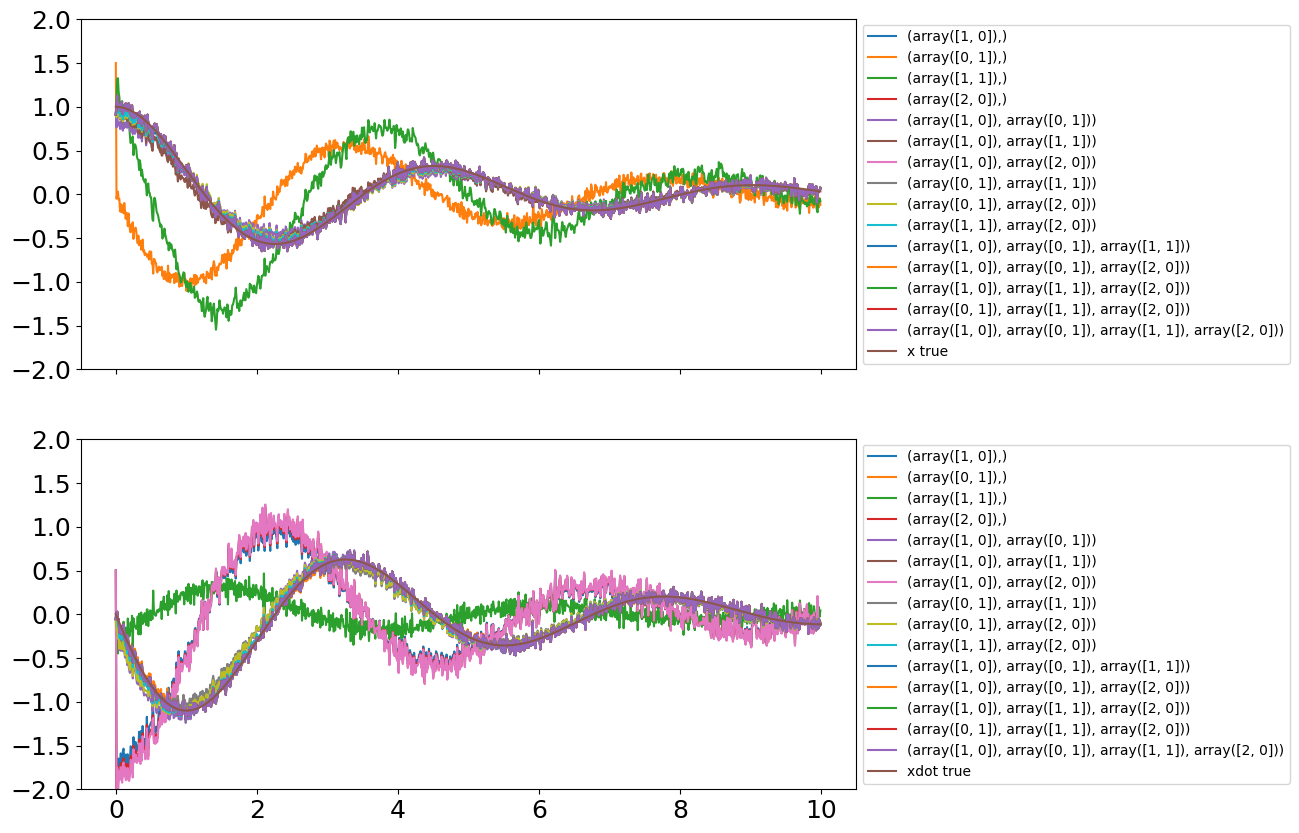

In [20]:
# plot x and xdot for all data sets in results
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
# set the font size
plt.rcParams.update({'font.size': 10})
for i in range(len(C)):
    ax[0].plot(t, results[i]['x'], label=C[i])
    ax[1].plot(t, results[i]['xdot'], label=C[i])
ax[0].plot(t, x, label='x true')
ax[1].plot(t, xdot, label='xdot true')

# set y limits
ax[0].set_ylim(-2, 2)
ax[1].set_ylim(-2, 2)

# put a legend to the right side
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))




# Analyze the error

DO everything for both position (x) and velocity (xdot)

In [21]:
# state estimate for x and xdot for each C matrix
x_hat = np.array([results[i]['x'] for i in range(len(C))])
xdot_hat = np.array([results[i]['xdot'] for i in range(len(C))])

# covaraicne for state x for each C matrix
Px = [results[i]['P'] for i in range(len(C))]
Pxdot = [results[i]['Pdot'] for i in range(len(C))]

Recall that P is the covariance, so its diagonals are the variance. Variance = (Standard Deviation)^2.


In theory, the errors in the estimates should be well approximated by a Normal distribution with zero mean and standard deviation determined by the diagonal element of P. Lets see.

/tmp/ipykernel_4324/4264145751.py:4: RuntimeWarning: invalid value encountered in double_scalars
  N_x = [scipy.stats.norm(0, np.mean(Px[i])**0.5) for i in range(len(C))]
/tmp/ipykernel_4324/4264145751.py:7: RuntimeWarning: invalid value encountered in double_scalars
  N_xdot = [scipy.stats.norm(0, np.mean(Pxdot[i])**0.5) for i in range(len(C))]


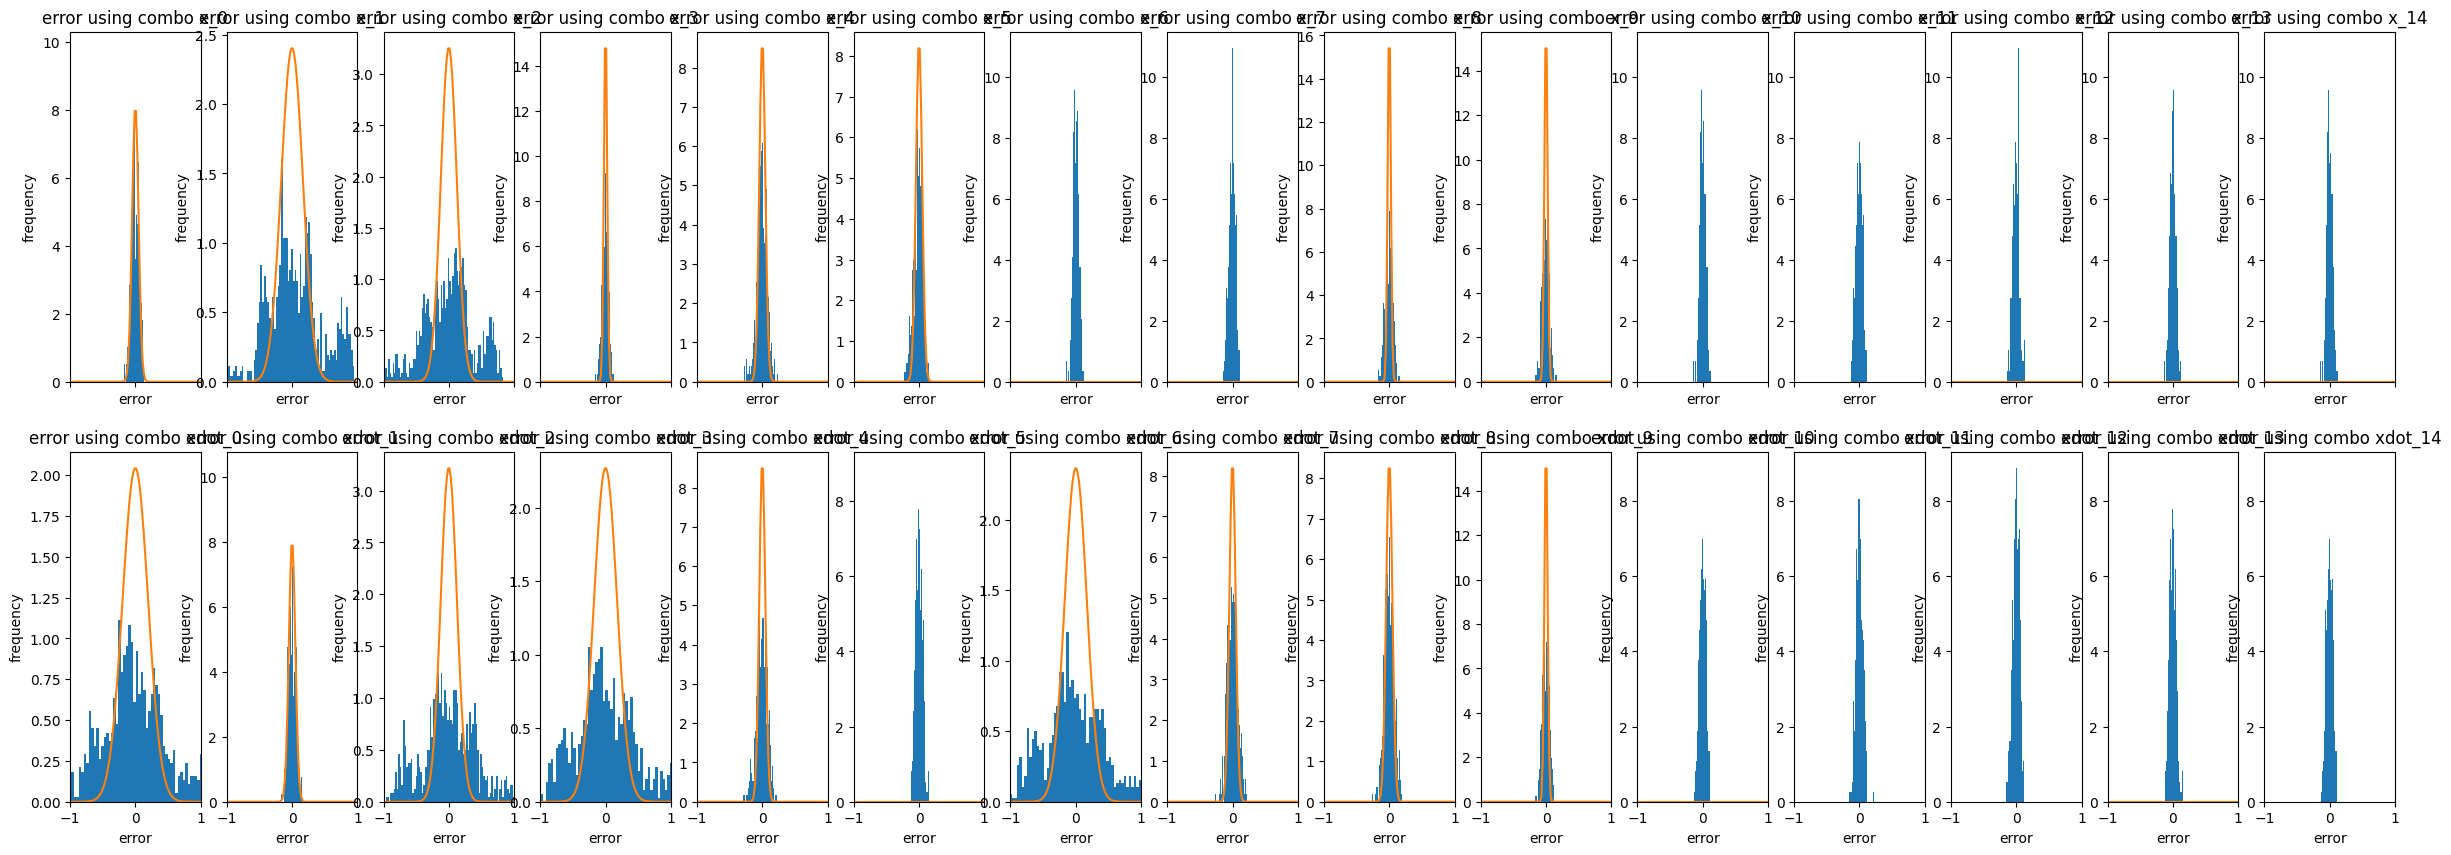

In [22]:
import scipy.stats

xr = np.linspace(-1, 1, 100)
N_x = [scipy.stats.norm(0, np.mean(Px[i])**0.5) for i in range(len(C))]
pdf_x = [N_x[i].pdf(xr) for i in range(len(C))]

N_xdot = [scipy.stats.norm(0, np.mean(Pxdot[i])**0.5) for i in range(len(C))]
pdf_xdot = [N_xdot[i].pdf(xr) for i in range(len(C))]

fig, ax = plt.subplots(2, len(x_hat), figsize=(30, 10), sharex=True) 

for i in range(len(x_hat)):
    ax[0, i].hist(x_hat[i]-x, bins=100, density=True)
    ax[0, i].plot(xr, pdf_x[i])
    ax[0, i].set_xlim(-1,1)
    ax[0, i].set_xlabel('error')
    ax[0, i].set_ylabel('frequency')
    ax[0, i].set_title('error using combo 'f'x_{i}')

for j in range(len(xdot_hat)):
    ax[1, j].hist(xdot_hat[j]-xdot, bins=100, density=True)
    ax[1, j].plot(xr, pdf_xdot[j])
    ax[1, j].set_xlim(-1,1)
    ax[1, j].set_xlabel('error')
    ax[1, j].set_ylabel('frequency')
    ax[1, j].set_title('error using combo 'f'xdot_{j}')

Furthermore, 97.7% of the errors should lie under the 3*$\sigma$ bounds. Let's see. 

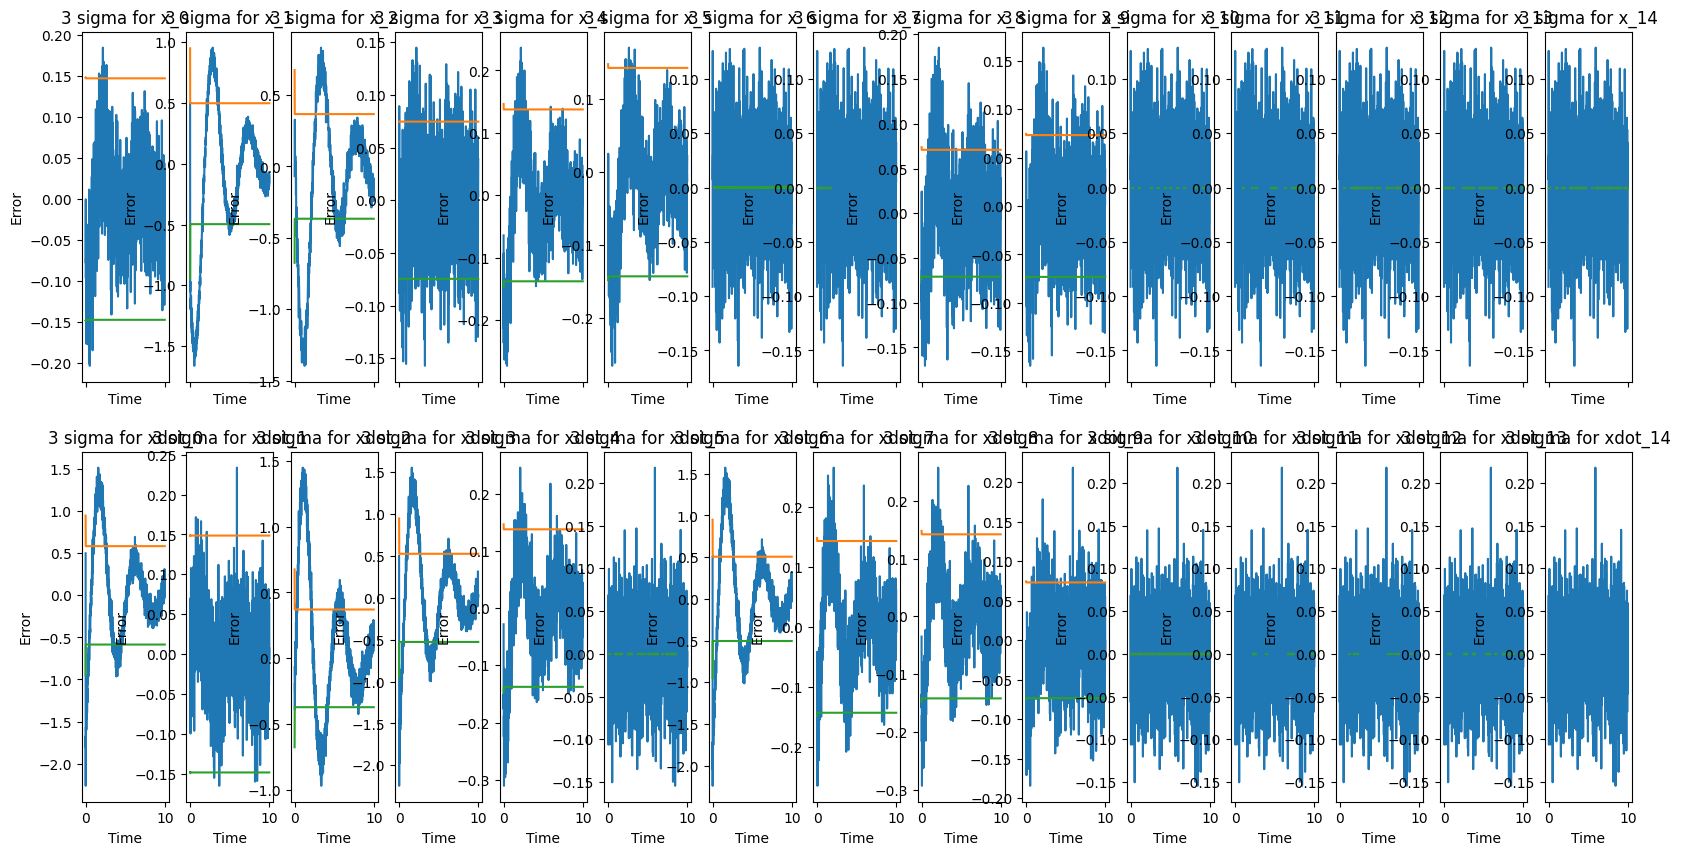

In [23]:
#sigma_x = Px**0.5
#sigma_xdot = Pxdot**0.5

sigma_x = [Px[i]**0.5 for i in range(len(C))]
sigma_xdot = [Pxdot[i]**0.5 for i in range(len(C))]

fig, ax = plt.subplots(2, len(sigma_x), figsize=(20, 10), sharex=True) 

for i in range(len(sigma_x)):
    ax[0, i].plot(t, x_hat[i]-x)
    ax[0, i].plot(t, 3*sigma_x[i])
    ax[0, i].plot(t, -3*sigma_x[i])
    ax[0, i].set_xlabel('Time')
    ax[0, i].set_ylabel('Error')
    ax[0, i].set_title('3 sigma for 'f'x_{i}')

for j in range(len(sigma_xdot)):
    ax[1, j].plot(t, xdot_hat[j]-xdot)
    ax[1, j].plot(t, 3*sigma_xdot[j])
    ax[1, j].plot(t, -3*sigma_xdot[j])
    ax[1, j].set_xlabel('Time')
    ax[1, j].set_ylabel('Error')
    ax[1, j].set_title('3 sigma for 'f'xdot_{j}')

# Plotting with Error

Now, I will plot my state estimates with a 3 sigma region

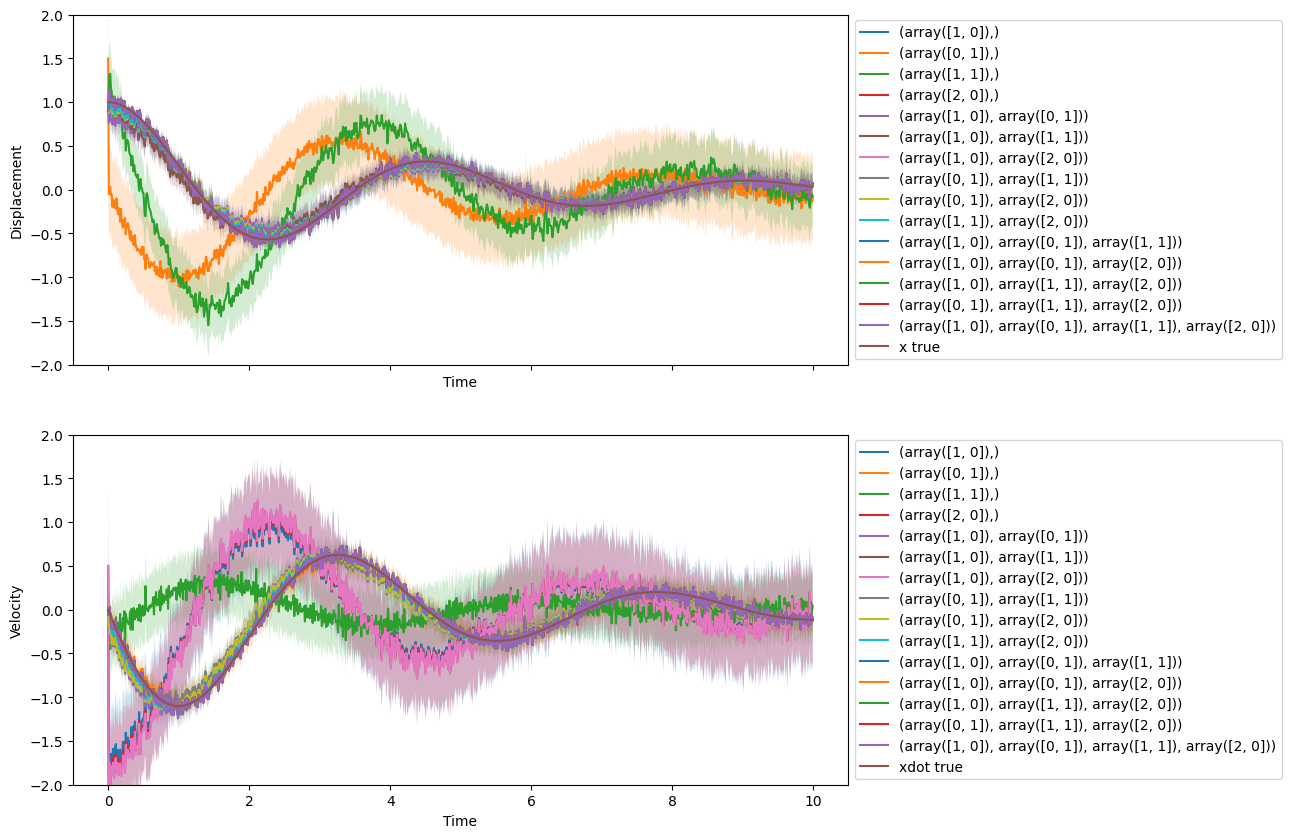

In [24]:
# Plot the state estimates of x and xdot with their 3 sigma bounds

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
plt.rcParams.update({'font.size': 10})
for i in range(len(C)):
    ax[0].plot(t, x_hat[i], label=C[i])
    ax[0].fill_between(t, x_hat[i]-3*sigma_x[i], x_hat[i]+3*sigma_x[i], alpha=0.2)
    ax[1].plot(t, xdot_hat[i], label=C[i])
    ax[1].fill_between(t, xdot_hat[i]-3*sigma_xdot[i], xdot_hat[i]+3*sigma_xdot[i], alpha=0.2)

ax[0].plot(t, x, label='x true')
ax[1].plot(t, xdot, label='xdot true')

ax[0].set_xlabel('Time')
ax[0].set_ylabel('Displacement')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')

ax[0].set_ylim(-2, 2)
ax[1].set_ylim(-2, 2)

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Sorting Out Based on Large Error

Now, I will try and disregard a sensor if the error in the sensor is large. 

In [25]:
# for every position and velocity, if the error is larger than 0.01, then we want to disregard the data
# we will use the covariance to determine if the data is trustworthy or not
trustworthy_x = []
trustworthy_xdot = []
for i in range(len(C)):
    if np.mean(Px[i]) < 0.01:
        trustworthy_x.append(i)
    else:
        continue
for j in range(len(C)):
    if np.mean(Pxdot[j]) < 0.01:
        trustworthy_xdot.append(j)
    else:
        continue

print(trustworthy_x)
print()
print(trustworthy_xdot)

[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

[1, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14]


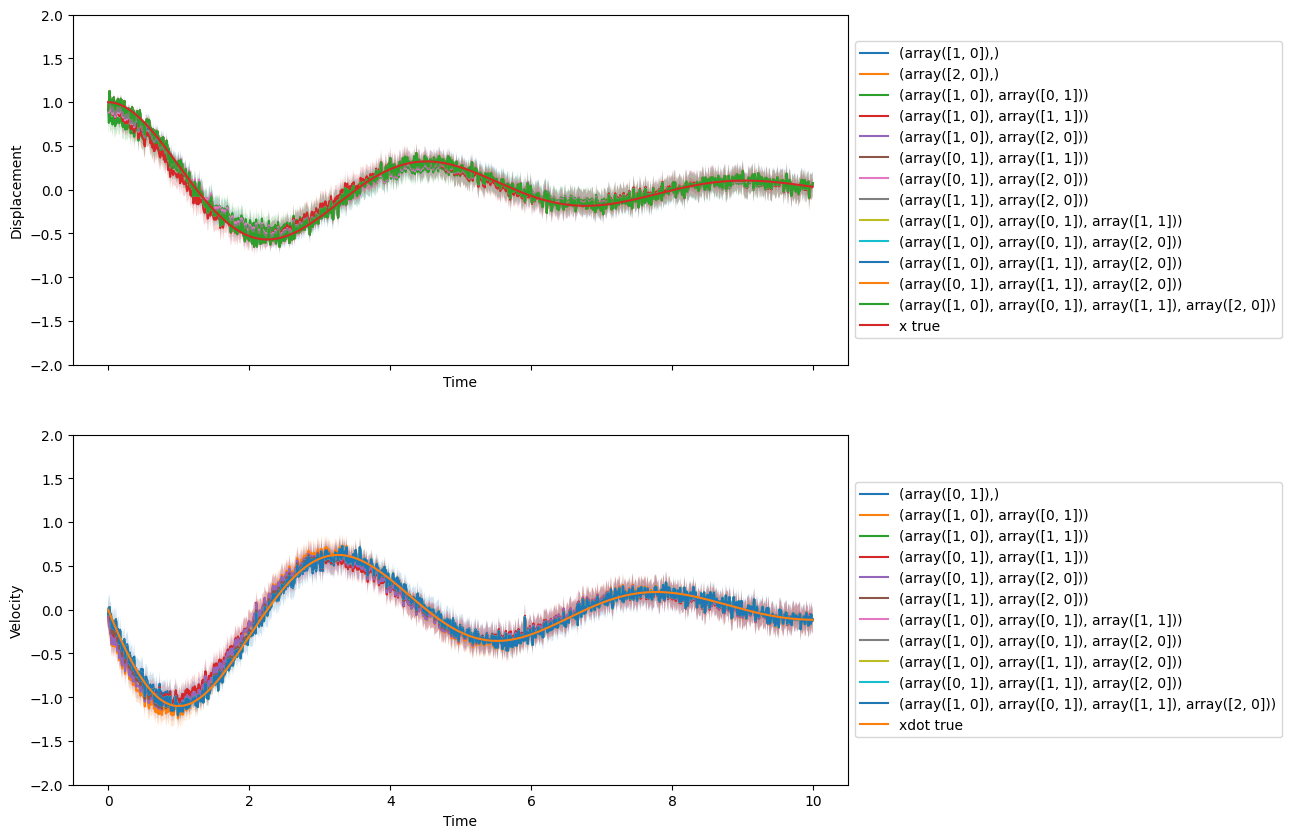

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
plt.rcParams.update({'font.size': 10})
for i in range(len(trustworthy_x)):
    j = trustworthy_x[i]
    ax[0].plot(t, x_hat[j], label=C[j])
    ax[0].fill_between(t, x_hat[j]-3*sigma_x[j], x_hat[j]+3*sigma_x[j], alpha=0.2)

ax[0].plot(t, x, label='x true')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Displacement')
ax[0].set_ylim(-2, 2)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for i in range(len(trustworthy_xdot)):
    j = trustworthy_xdot[i]
    ax[1].plot(t, xdot_hat[j], label=C[j])
    ax[1].fill_between(t, xdot_hat[j]-3*sigma_xdot[j], xdot_hat[j]+3*sigma_xdot[j], alpha=0.2)

ax[1].plot(t, xdot, label='xdot true')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
ax[1].set_ylim(-2, 2)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Agreement Heatmap
Now, put all the 'trustworthy' measurements into a heatmap to see how well they agree with one another. 

In [28]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

overlaps_x = np.ones((len(trustworthy_x), len(trustworthy_x)))

# check if a state estiamte for position overlaps with the uncertainty range of all other position estimates. Only do this with the trustworthy estimates
for i in range(len(trustworthy_x)):
    for j in range(len(trustworthy_x)):
        k = trustworthy_x[i]
        l = trustworthy_x[j]
        if k != l:
            overlap = np.sum((results[k]['x'] + results[k]['Px'] > results[l]['x']) & (reults[l]['x'] - results[k]['Px'] < results[l]['x'])) / len(results[k])
            overlaps_x[i,j] = overlap


KeyError: 'Px'